In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd

from wvz_helpers import skims, load_dataframes
from geeksw.geeklearn.metrics import calibration_curve
from geeksw.geeklearn import sigmoid

In [2]:
nonh_only = False

if nonh_only:
    backgrounds = [
        "zz",
        "ttz",
        "twz",
        "wz",
        "higgs",
        "othernoh",
        "zh_zzz",
        "zh_wwz",
        "wh_wzz",
    ]
    signals = [
        "nonh_wwz",
        "nonh_wzz",
        "nonh_zzz",
    ]
else:
    backgrounds = [
        "zz",
        "ttz",
        "twz",
        "wz",
        "higgs",
        "othernoh",
    ]
    signals = [
        "nonh_wwz",
        "nonh_wzz",
        "nonh_zzz",
        "zh_zzz",
        "zh_wwz",
        "wh_wzz",
    ]

In [3]:
data_background = load_dataframes(backgrounds, concat=True, exclude_training=True)
data_signal = load_dataframes(signals, concat=True, exclude_training=True)

In [4]:
data_background["is_signal"] = False
data_signal["is_signal"] = True

In [5]:
columns = ["weight", "emu_wwz_vs_ttz_score", "emu_wwz_vs_zz_score", "is_signal", "is_ChannelEMu", "sample"]

In [6]:
data = pd.concat([data_signal[columns], data_background[columns]], ignore_index=True)
data = data.query("is_ChannelEMu").copy()

In [10]:
def get_calibration(data, background_sample):
    from scipy.optimize import minimize
    
    signal = data.query("sample == 'nonh_wwz' or sample == 'zh_wwz'")
    background = data.query(f"sample == '{background_sample}'")
    
    score_label = f"emu_wwz_vs_{background_sample}_score"
    preds = np.concatenate([signal[score_label].values, background[score_label].values])
    weights = np.concatenate([signal["weight"].values, background["weight"].values])

    y_true = np.zeros(len(preds), dtype=np.int)
    y_true[:len(signal)] = 1

    def func_to_optimize(x):
        preds = np.concatenate([signal[score_label].values, background[score_label].values])
        preds = sigmoid((preds-x[0])*x[1])
    
        th, rhs = calibration_curve(y_true, preds, sample_weight=weights)
    
        return np.sum((rhs-th)**2)

    return minimize(func_to_optimize, [1.5, 1], method='Nelder-Mead', tol=1e-6)

In [22]:
def get_calibration_transformations(data):
    x_ttz = get_calibration(data, "ttz").x
    x_zz = get_calibration(data, "zz").x
    
    print("ttz", f"(z - {x_ttz[0]}) * {x_ttz[1]}")
    print("zz", f"(z - {x_zz[0]}) * {x_zz[1]}")
    
    return dict(
        ttz = lambda z: (z - x_ttz[0]) * x_ttz[1],
        zz = lambda z: (z - x_zz[0]) * x_zz[1],
    )

In [23]:
transformations = get_calibration_transformations(data)

ttz (z - 1.0057803179362228) * 0.5939423882575803
zz (z - -0.2238330124205508) * 0.8890006701784727


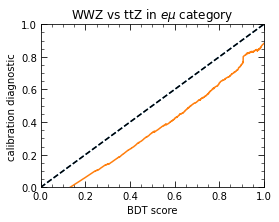

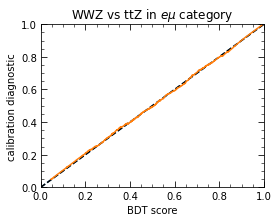

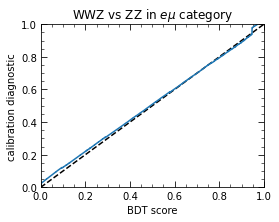

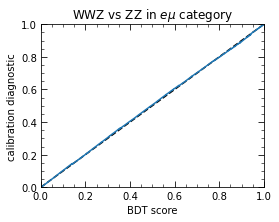

In [31]:
for background_sample in ["ttz", "zz"]:
    
    for apply_calibration in [False, True]:

        signal = data.query("sample == 'nonh_wwz' or sample == 'zh_wwz'")
        background = data.query(f"sample == '{background_sample}'")
        #print(len(signal), len(background))
    
        score_label = f"emu_wwz_vs_{background_sample}_score"
        preds = np.concatenate([signal[score_label].values, background[score_label].values])
        weights = np.concatenate([signal["weight"].values, background["weight"].values])

        if apply_calibration:
            preds = sigmoid(transformations[background_sample](preds))
        else:
            preds = sigmoid(preds)

        y_true = np.zeros(len(preds), dtype=np.int)
        y_true[:len(signal)] = 1
    
        th, rhs = calibration_curve(y_true, preds, sample_weight=weights, curve_type='stitched')

        plt.figure(figsize=(4, 3))
        if background_sample == "ttz":
            plt.plot([0, 1], [0, 1], '--')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.plot(th, rhs)
        plt.xlim(0,1)
        plt.ylim(0,1)
        sample_name = background_sample.upper().replace("T", "t")
        plt.title(f"WWZ vs {sample_name} in $e\mu$ category")
        plt.xlabel(r"BDT score")
        plt.ylabel(r"calibration diagnostic")
        #if apply_calibration:
        #    plt.savefig(f"calibrated_likelihood_{apply_calibration}_cdf.pdf")
        #else:
        #    plt.savefig(f"uncalibrated_likelihood_{apply_calibration}_cdf.pdf")
        plt.close()

## Histogram method

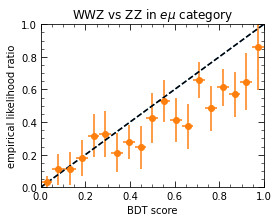

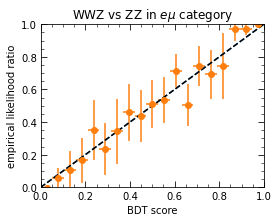

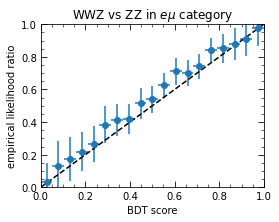

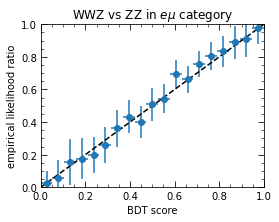

In [36]:
for background_sample in ["ttz", "zz"]:
    
    for apply_calibration in [False, True]:
        
        signal = data.query("sample == 'nonh_wwz' or sample == 'zh_wwz'")
        background = data.query(f"sample == '{background_sample}'")
        
        score_label = f"emu_wwz_vs_{background_sample}_score"

        bins = np.linspace(0, 1, 20)

        def centers(a):
            return (a[1:] + a[:-1])/2.
        def widths(a):
            return (a[1:] - a[:-1])/2.

        def correction(x):
            if apply_calibration:
                return transformations[background_sample](x)
            else:
                return x

        h_sig = np.histogram(sigmoid(correction(signal[score_label])),
                             bins=bins,
                             weights=signal["weight"])[0]
        h_bkg = np.histogram(sigmoid(correction(background[score_label])),
                             bins=bins,
                             weights=background["weight"])[0]
        h_sig = h_sig/np.sum(h_sig)
        h_bkg = h_bkg/np.sum(h_bkg)

        plt.figure(figsize=(4, 3))
        ratio = h_sig / (h_sig + h_bkg)
        ratio_err = np.sqrt(h_bkg**2 * h_sig + h_sig**2 * h_bkg) /(h_sig + h_bkg)
        if background_sample == "ttz":
            plt.plot([0, 1], [0, 1], '--')
        plt.errorbar(centers(bins), ratio, xerr=widths(bins), yerr=ratio_err, fmt='o')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim(0,1)
        plt.ylim(0,1)
        plt.title("WWZ vs ZZ in $e\mu$ category")
        plt.xlabel(r"BDT score")
        plt.ylabel(r"empirical likelihood ratio")
        #if apply_calibration:
        #    plt.savefig(f"calibrated_likelihood_{apply_calibration}.pdf")
        #else:
        #    plt.savefig(f"uncalibrated_likelihood_{apply_calibration}.pdf")
        plt.close()

## Mixture model for signal and two major backgrounds

In [37]:
df_main = data.query("sample == 'nonh_wwz' or sample == 'zh_wwz' or sample == 'zz' or sample == 'ttz'").copy()
weights = df_main["weight"].values

In [38]:
df_main["sample_idx"] = 0
df_main.loc[df_main.eval("sample == 'ttz'"),"sample_idx"] = 1
df_main.loc[df_main.eval("sample == 'zz'"),"sample_idx"] = 2

Fill the matrix of log-likelihood ratios:

In [39]:
log_likelihood_matrix = np.zeros((len(df_main), 3, 3)) # diagonal remains zero
# the elements that involve no signal also remain zero, because we don't care about separating backgrounds
log_likelihood_matrix[:,0,1] = transformations["ttz"](df_main["emu_wwz_vs_ttz_score"])
#log_likelihood_matrix[:,0,1] = df_main["emu_wwz_vs_ttz_score"]
log_likelihood_matrix[:,1,0] = -log_likelihood_matrix[:,0,1]

log_likelihood_matrix[:,0,2] = transformations["zz"](df_main["emu_wwz_vs_zz_score"])
#log_likelihood_matrix[:,0,2] = df_main["emu_wwz_vs_zz_score"]
log_likelihood_matrix[:,2,0] = -log_likelihood_matrix[:,0,2]

log_likelihood_matrix[:,1,2] =  log_likelihood_matrix[:,0,2] - log_likelihood_matrix[:,0,1]
log_likelihood_matrix[:,2,1] = -log_likelihood_matrix[:,1,2]

In [40]:
yields = df_main.groupby("sample_idx")["weight"].sum().values
#yields = np.ones(3)
#yields =  yields[:-1]

In [41]:
def get_final_log_likelihood_ratio(log_likelihood_matrix):
    
    n_classes = log_likelihood_matrix.shape[-1]

    w_1 = yields / np.sum(yields)
    w_0 = np.copy(w_1)
    
    # set signal to zero for null hypothesis
    w_0[0] *= 1e-10
    w_1[0] *= 1
    w_1[1:] = 0
    w_0 /= np.sum(w_0)
    w_1 /= np.sum(w_1)

    w_r = np.zeros((n_classes, n_classes))
    for i in range(n_classes):
        for j in range(n_classes):
            w_r[i, j] = w_1[j] / w_0[i]

    inner_sum = 1.0 / np.sum(w_r * np.exp(-log_likelihood_matrix), axis=-1)

    l_ratios = np.sum(inner_sum, axis=-1)

    return np.log(l_ratios)

In [42]:
data.groupby("sample")["weight"].sum()

sample
higgs        1.457694
nonh_wwz     7.855559
nonh_wzz     0.432804
nonh_zzz     0.047272
othernoh     1.011708
ttz          4.126676
twz          1.554189
wh_wzz       0.337550
wz           1.510212
zh_wwz       6.483943
zz          17.539599
Name: weight, dtype: float64

In [43]:
df_main["emu_wwz_score"] = -get_final_log_likelihood_ratio(log_likelihood_matrix)

-10.01933183285985


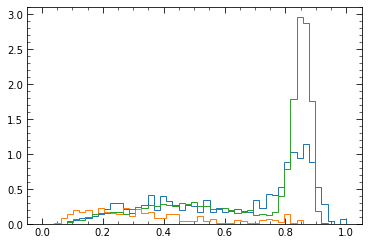

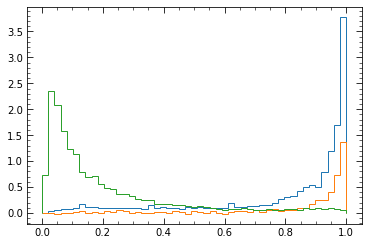

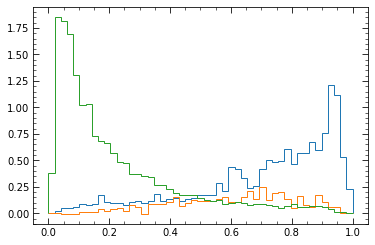

In [44]:
bins = np.linspace(0, 1, 50)
#bins = np.linspace(-1, 2.5, 100)
#print(sigmoid(df_q["emu_wwz_score"])
print(np.sum(df_main["emu_wwz_score"]  * df_main["weight"]))

for i in range(3):
    df_q = df_main.query(f"sample_idx == {i}")
    plt.hist(sigmoid(transformations["ttz"](df_q["emu_wwz_vs_ttz_score"])), bins=bins,
             weights=df_q["weight"], histtype="step")
plt.close()

for i in range(3):
    df_q = df_main.query(f"sample_idx == {i}")
    plt.hist(sigmoid(transformations["zz"](df_q["emu_wwz_vs_zz_score"])), bins=bins,
             weights=df_q["weight"], histtype="step")
plt.close()

for i in range(3):
    df_q = df_main.query(f"sample_idx == {i}")
    plt.hist(sigmoid(df_q["emu_wwz_score"]), bins=bins,
             weights=df_q["weight"], histtype="step")
plt.close()

In [45]:
n_other = 0#5.534

In [46]:
def likelihood(mu, n_events_only=False):
    
    n_tot = np.sum(df_main["weight"]) + n_other
    
    #n_classes = log_likelihood_matrix.shape[-1]

    #n_0 = np.sum(yields)
    #w_0 = yields / n_0
    #w_1 = np.copy(w_0) * n_0

    #w_1[0] *= mu
    #n_1 = np.sum(w_1)
    #w_1 /= np.sum(w_1)
    
    n_classes = log_likelihood_matrix.shape[-1]

    w_1 = np.copy(yields)
    w_0 = np.copy(w_1)
    
    # set signal to zero for null hypothesis
    w_0[0] = w_0[0] * 1.
    w_1[0] = w_1[0] * mu
    
    n_0 = np.sum(w_0) + n_other
    n_1 = np.sum(w_1) + n_other

    w_0 /= np.sum(w_0)
    w_1 /= np.sum(w_1)

    w_r = np.zeros((n_classes, n_classes))
    for i in range(n_classes):
        for j in range(n_classes):
            w_r[i, j] = w_1[j] / w_0[i]

    extended = float(n_tot) * (np.log(n_0) - np.log(n_1)) - n_0 + n_1

    inner_sum = 1.0 / np.sum(w_r * np.exp(-log_likelihood_matrix), axis=-1)

    l_ratios = np.sum(inner_sum, axis=-1)

    if n_events_only:
        return extended
    return np.sum(np.log(l_ratios) * df_main["weight"]) + extended
    return np.sum(-np.log(l_ratios) * df_main["weight"]) + extended

In [47]:
likelihood(1)

-7.294379084202147e-16

In [48]:
from geeksw.stats.likelihood import minimize_likelihood

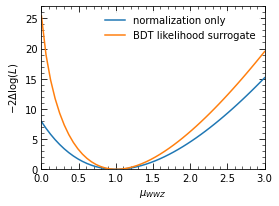

best mu: (1.0064040029855714, array([0.70375039, 1.36254861]))


In [49]:
mus = np.linspace(-0.0, 3, 50)
res = np.zeros_like(mus)

plt.figure(figsize=(4, 3))

for k, m in enumerate(mus):
    res[k] = likelihood(m, n_events_only=True)
plt.plot(mus, res*2, label="normalization only")

res = np.zeros_like(mus)

for k, m in enumerate(mus):
    res[k] = likelihood(m)
plt.plot(mus, res*2, label="BDT likelihood surrogate")


plt.ylabel(r"$-2\Delta\log(L)$")
plt.xlabel(r"$\mu_{WWZ}$")
plt.legend()
plt.xlim(-0.0,3)
plt.ylim(0, 27)
plt.savefig("likelihood_surrogate_scan.pdf")
plt.show()

print("best mu: " + str(minimize_likelihood(likelihood)))

In [50]:
print(np.sqrt(2*likelihood(0))) # 6.2844483250389835 uncalibrated

5.03905341864123

In [51]:
print(np.sqrt(2*likelihood(0)))

5.03905341864123